In [2]:
import torch
import wandb
from torch.utils.data import DataLoader
import argparse
import json
import datasets
import utils
import models
import collate_fn
import os
from torch.nn import MSELoss
from gudhi.representations.vector_methods import PersistenceImage as PersistenceImageGudhi
from scipy.spatial import distance_matrix
import numpy as np


def compute_pimgr_parameters(diagrams):
    min_b, max_b, min_p, max_p = 0., 0., 0., 0.
    sigma = 0.
    n_total = 0
    for pd in diagrams:
        pd = pd.numpy()
        min_b = min(min_b, np.min(pd[..., 0]))
        max_b = max(max_b, np.max(pd[..., 0]))
        min_p = min(min_p, np.min(pd[..., 1] - pd[..., 0]))
        max_p = max(max_p, np.max(pd[..., 1] - pd[..., 0]))
        
        pairwise_distances = np.triu(distance_matrix(pd, pd)).flatten()
        pairwise_distances = pairwise_distances[pairwise_distances > 0]
        if len(pairwise_distances) != 0:
            sigma += np.quantile(pairwise_distances, q=0.2)
            n_total += 1
            
    im_range = [min_b, max_b, min_p, max_p]
    sigma /= n_total
        
    return sigma, im_range


def val_step(model, valloader, pimgr, device):
    model.eval()
    pie = 0.
    mse = MSELoss(reduction='sum')
    val_len = len(valloader.dataset)
    for item in valloader:
        X, Z, v = item['items'], item['pds'], item['labels']
        with torch.no_grad():
            Z = Z[..., :2].to(torch.float32)
            PI_pred = model(X.to(device))
            PI_real = torch.from_numpy(pimgr.fit_transform(Z)).to(torch.float32).to(device)
            pie += mse(PI_pred, PI_real)
    # TODO: add image logging

def train_loop(model, trainloader, valloader, optimizer, pimgr, device, scheduler=None, n_epochs=25, clip_norm=None):
    torch.manual_seed(0)
    loss_fn = MSELoss()
    
    for _ in range(n_epochs):
        model.train()
        for item in trainloader:
            X, Z, v = item['items'], item['pds'], item['labels']
            optimizer.zero_grad()
            
            Z = Z[..., :2].to(torch.float32)
            PI_pred = model(X.to(device))
            PI_real = torch.from_numpy(pimgr.fit_transform(Z)).to(torch.float32).to(device)

            loss = loss_fn(PI_pred, PI_real)
            
            loss.backward()
            print(loss.item())
            
            if clip_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
                
            optimizer.step()
            
            if scheduler is not None:
                scheduler.step()

            total_norm = 0
            parameters = [p for p in model.parameters() if p.grad is not None and p.requires_grad]
            for p in parameters:
                param_norm = p.grad.detach().data.norm(2)
                total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            lr = optimizer.param_groups[0]['lr']
        
        val_step(model, valloader, pimgr, device)
    return model

In [3]:
! python prepare_dataset.py -c configs/data_configs/mnist_dir10_config.json

0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [3]:

    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

path = 'configs/train_configs/pinet_mnist_dir_10.json'
f = open(path)
config = json.load(f)

train_dataset = getattr(datasets, config['data']['train']['dataset']['type'])(**config['data']['train']['dataset']['args'])
test_dataset = getattr(datasets, config['data']['test']['dataset']['type'])(**config['data']['test']['dataset']['args'])

collator = getattr(collate_fn, config['collator']['type'])

trainloader = DataLoader(train_dataset, batch_size=config['data']['train']['batch_size'], 
                         num_workers=config['data']['train']['num_workers'], shuffle=True, drop_last=True, collate_fn=collator)
testloader = DataLoader(test_dataset, batch_size=config['data']['test']['batch_size'], 
                        num_workers=config['data']['test']['num_workers'], shuffle=False, collate_fn=collator)


model = getattr(models, config['arch']['type'])(**config['arch']['args']).to(device)

optimizer = getattr(torch.optim, config['optimizer']['type'])(model.parameters(), **config['optimizer']['args'])
scheduler = getattr(torch.optim.lr_scheduler, config['lr_scheduler']['type'])(optimizer, **config['lr_scheduler']['args'])

#sigma, im_range = compute_pimgr_parameters(train_dataset.pds)
#
#pimgr = PersistenceImageGudhi(bandwidth=sigma,
#                              resolution=[50, 50],
#                              weight=lambda x: (x[1])**2,
#                              im_range=im_range)

#final_model = train_loop(model, trainloader, testloader, optimizer, pimgr, device, 
#                         scheduler, n_epochs=config["trainer"]["n_epochs"], clip_norm=config["trainer"]["grad_norm_clip"])

##os.makedirs('pretrained_models', exist_ok=True)
#torch.save(final_model.state_dict(), f'pretrained_models/{run}_model.pth')

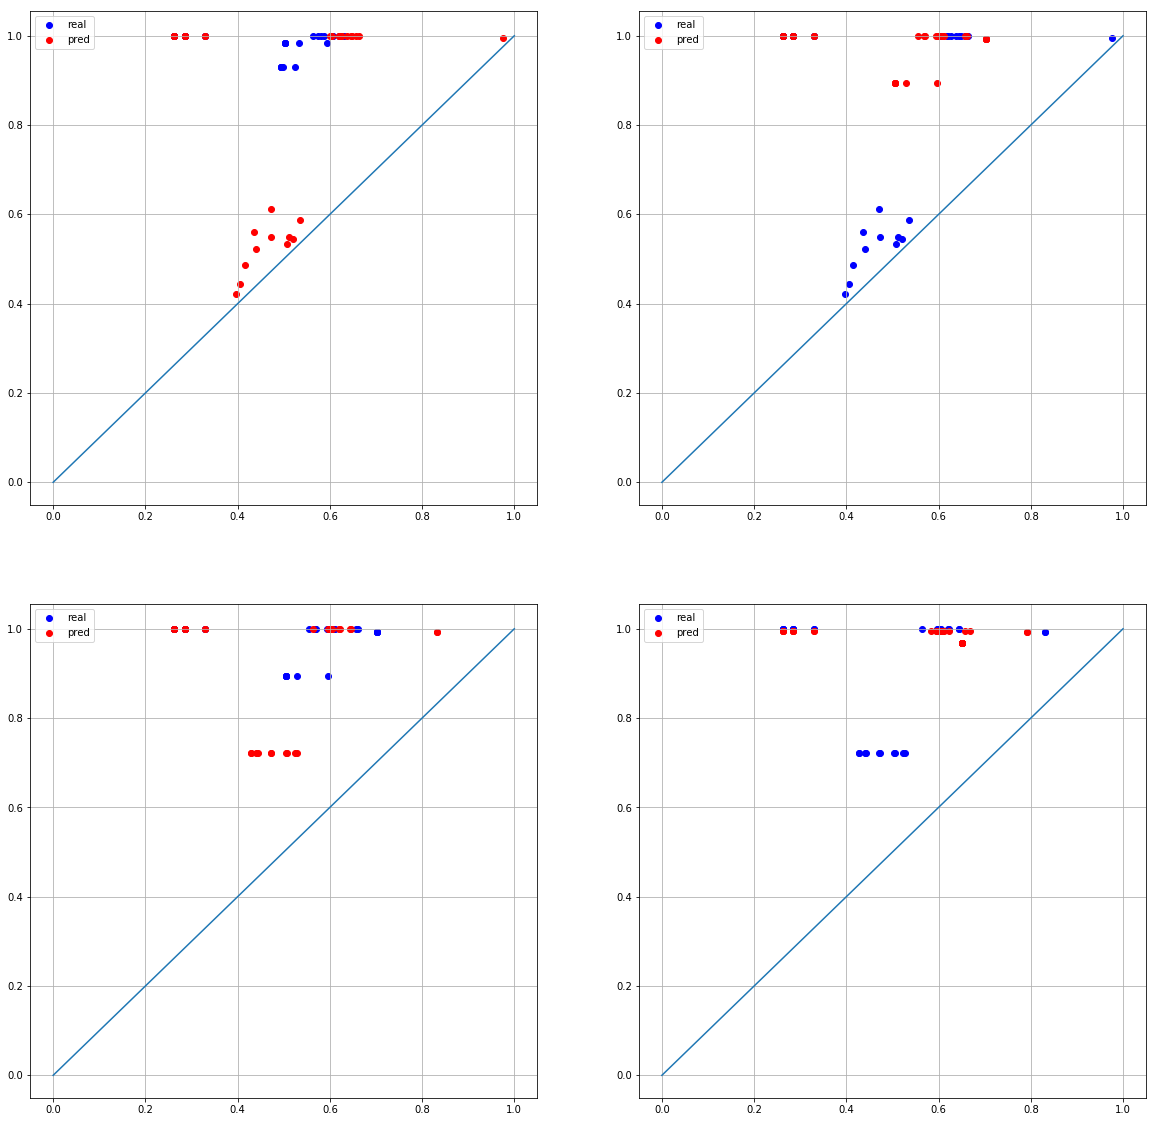

In [18]:
from matplotlib import pyplot as plt
import numpy as np

for item in trainloader:
    X, Z, v = item['items'], item['pds'], item['labels']
    
    with torch.no_grad():
        Z = Z[..., :2].to(torch.float32)
        
    fig, axs = plt.subplots(2, 2, figsize=(20,20))
    
    line = np.linspace(0, 1, 100)
    for i in range(4):
        
        axs[i // 2, i % 2].scatter(Z[i, :, 0], Z[i, :, 1], c='b', label='real')
        axs[i // 2, i % 2].scatter(Z[i+1, :, 0], Z[i+1, :, 1], c='r', label='pred')
        axs[i // 2, i % 2].legend()
        axs[i // 2, i % 2].plot(line, line)
        axs[i // 2, i % 2].grid()
    
    plt.show()
    
    break

In [32]:
PI_real.max(dim=1)[0]

tensor([[2.7356e-10, 6.7342e-09, 1.2826e-07,  ..., 9.7610e-15, 1.6492e-16,
         2.1531e-18],
        [2.6761e-10, 6.5858e-09, 1.2539e-07,  ..., 2.0047e-02, 5.7047e-03,
         1.2539e-03],
        [2.7056e-10, 6.6603e-09, 1.2686e-07,  ..., 1.4310e-14, 2.2547e-16,
         2.7452e-18],
        ...,
        [2.7056e-10, 6.6603e-09, 1.2686e-07,  ..., 3.2265e-11, 9.7177e-13,
         2.2625e-14],
        [2.6990e-10, 6.6442e-09, 1.2655e-07,  ..., 1.6819e-02, 5.8416e-03,
         1.5671e-03],
        [2.7056e-10, 6.6603e-09, 1.2686e-07,  ..., 1.4652e-02, 6.8621e-03,
         2.4823e-03]])

In [26]:
im_range

[0.0, 0.9960784316062927, 0.0, 0.7381034392506136]

In [25]:
kek = {
    "a": 1
}
if 'a' in kek:
    print(0)
else:
    print(1)

0


In [37]:
a = np.array([1 ,2 ,3, 4])
lol = torch.from_numpy(a)

for m in lol:
    print(m)

tensor(1, dtype=torch.int32)
tensor(2, dtype=torch.int32)
tensor(3, dtype=torch.int32)
tensor(4, dtype=torch.int32)


In [50]:
v = torch.randn(64, 1, 50, 50)
v.shape

torch.Size([64, 1, 50, 50])

In [51]:
import torchvision
kek = torchvision.utils.make_grid(v)
kek[0].shape

torch.Size([418, 418])

In [ ]:
fig, axs = plt.subplots(2, 2)